This notebook provides the plotting functions for Figure 4 a-c, rightmost columns. This is the equality test for functional equality using glutamate responses to local and global chirp.

In [1]:
%matplotlib inline

from datetime import datetime 
import GPy
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice
import os
import pandas as pd
import seaborn as sns
import tqdm

In [2]:
from util.load_hdf5 import *
from util.zscore import *
from util.compute_bounds import *
from util.plot_roi import *
from util.fill_bounds import *

In [3]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = "arial"

%config InlineBackend.figure_format = 'png'

sns.set_style('white')

title_fontsize = 13
label_fontsize = 12

fig_p = {
    'dpi': 600, 
    'bbox_inches': 'tight'
}

In [4]:
directories = json.load(open('directories.json'))

data_spiral = load_hdf5(directories['data'] + 'SMP_M1_RR2_IPL2OFF_ChirpI.h5')
data_spiral_df = pd.read_csv(directories['data'] + 'SMP_M1_RR2_IPL2OFF_ChirpI.csv', index_col = 0)
data_spiral_df = data_spiral_df.groupby(['roi', 'frame']).mean().reset_index()

In [5]:
zscore_single = lambda ndarray: (ndarray - ndarray.mean()) / ndarray.std()

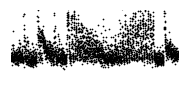

In [6]:
sns.set_style('white')

roi = np.unique(data_spiral_df['roi'])[3]

traces = data_spiral_df.loc[data_spiral_df['roi'] == roi, 'y']
tpnts  = data_spiral_df.loc[data_spiral_df['roi'] == roi, 'x_t']
tpnts_warp  = data_spiral_df.loc[data_spiral_df['roi'] == roi, 'x_t_warped']

stimulus_duration = 66

stimulus_mask = tpnts < (stimulus_duration / 2)
traces  = traces[stimulus_mask]
tpnts  = tpnts[stimulus_mask]
tpnts_warp = tpnts_warp[stimulus_mask]

fig, ax = plt.subplots(1)

ax.scatter(tpnts, traces, color = 'k', s = 0.5)

ax.set_xlim(0, stimulus_duration / 2);
ax.set_ylim(-3, 3)
plt.tick_params(axis='both', which='major', labelsize='small')
ax.set_xlabel('', fontsize=10)
ax.set_xticklabels([]);
ax.set_yticklabels([]);
sns.despine(left = True, bottom = True, ax = ax)

fig.set_size_inches(3, 1.5)

# plt.tight_layout()

plt.savefig(directories['figs'] + 'reconstruct/' + 'raw_data_points_glu.svg', **fig_p)

In [7]:
y = traces[:, None]
x = tpnts[:, None] #- stimulus_duration / 2

In [8]:
m1 = GPy.models.SparseGPRegression(
    x,
    y,
    num_inducing = 300,
    kernel = GPy.kern.RBF(1)
)

m1.optimize_restarts(4, messages = True, max_iters = 25)

Optimization restart 1/4, f = 2731.241912715853


Optimization restart 2/4, f = 4293.790164927468


Optimization restart 3/4, f = 4293.666827831556


Optimization restart 4/4, f = 4293.665947094869


In [9]:
x_new = np.linspace(0, stimulus_duration / 2, 33 * 24)[:, None]

mu, sig = m1.predict(x_new, include_likelihood = False)
_, sig_outer = m1.predict(x_new, include_likelihood = True)

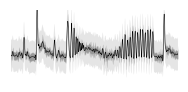

In [10]:
sns.set_style('white')

fig, ax = plt.subplots(1)

ax.plot(x_new, mu, color = 'k', linewidth = 0.5)

upper, lower = compute_bounds(mu, sig, n_sigma = 3)
  
ax.fill_between(
    x_new[:, 0], 
    upper[:, 0], 
    lower[:, 0], 
    facecolor = 'k',
    alpha = 0.33
)

upper, lower = compute_bounds(mu, sig_outer, n_sigma = 3)
  
ax.fill_between(
    x_new[:, 0], 
    upper[:, 0], 
    lower[:, 0], 
    facecolor = 'k',
    alpha = 0.1
)

ax.set_xlim(0, stimulus_duration / 2);
ax.set_ylim(-3, 4);
plt.tick_params(axis='both', which='major', labelsize='small')
ax.set_xlabel('', fontsize=10)
ax.set_xticklabels([]);
ax.set_yticklabels([]);
sns.despine(left = True, bottom = True, ax = ax)
ax.set_aspect(2)

fig.set_size_inches(3, 1.5)

plt.savefig(directories['figs'] + 'reconstruct/' + 'fitted_gaussian_process_glu.svg', **fig_p)

In [11]:
y = traces[:, None]
X = tpnts_warp[:, None]

m2 = GPy.models.SparseGPRegression(
    X,
    y,
    num_inducing = 300,
    kernel = GPy.kern.RBF(1)
)

m2.optimize_restarts(4, messages = False, max_iters = 20)

Optimization restart 1/4, f = 2866.793513278448
Optimization restart 2/4, f = 4208.455143270053
Optimization restart 3/4, f = 4164.00778619615
Optimization restart 4/4, f = 4163.432866125822


In [12]:
from sklearn.isotonic import IsotonicRegression

iso_reg = IsotonicRegression()
stimulus_mask = data_spiral_df['x_t'] < 33
iso_reg.fit(data_spiral_df['x_t_warped'][stimulus_mask], data_spiral_df['x_t'][stimulus_mask])

n_tpnts = 32 * 20
x_new = np.linspace(data_spiral_df['x_t'].min(), data_spiral_df['x_t'].max() / 2, n_tpnts)
x_new_unwarp = iso_reg.transform(x_new)

mu, sig = m2.predict(x_new[:, None], include_likelihood = False)
_, sig_outer = m2.predict(x_new[:, None], include_likelihood = True)

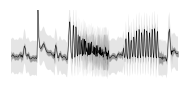

In [13]:
sns.set_style('white')

fig, ax = plt.subplots(1)

ax.plot(x_new_unwarp, mu, color = 'k', linewidth = 0.5)

upper, lower = compute_bounds(mu, sig, n_sigma = 3)
  
ax.fill_between(
    x_new_unwarp, 
    upper[:, 0], 
    lower[:, 0], 
    facecolor = 'k',
    alpha = 0.33
)

upper, lower = compute_bounds(mu, sig_outer, n_sigma = 3)
  
ax.fill_between(
    x_new_unwarp, 
    upper[:, 0], 
    lower[:, 0], 
    facecolor = 'k',
    alpha = 0.1
)

ax.set_xlim(0, 32);
ax.set_ylim(-3, 4);
plt.tick_params(axis='both', which='major', labelsize='small')
ax.set_xlabel('', fontsize=10)
ax.set_xticklabels([]);
ax.set_yticklabels([]);
sns.despine(left = True, bottom = True, ax = ax)
ax.set_aspect(2)

fig.set_size_inches(3, 1.5)

plt.savefig(directories['figs'] + 'reconstruct/' + 'fitted_gaussian_process_glu_warp.svg', **fig_p)

In [14]:
# x_new = np.linspace(0, stimulus_duration / 2, 33 * 16)[:, None]
n_samples = 5
mu_post = m1.posterior_samples_f(x_new[:, None], size = n_samples)

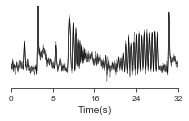

In [15]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

sample_colors = sns.color_palette('hls', n_samples)

offset = 0

for itx in range(n_samples):
    ax.plot(x_new, mu_post[:, 0, itx] + itx * offset, color = 'k', alpha = 0.5, linewidth = 0.5)
    
ax.set_xlim(0, 32);
ax.set_ylim(-2, 4);
plt.tick_params(axis='both', which='major', labelsize='small')
ax.set_xlabel('Time(s)', fontsize=10)
ax.set_yticklabels([]);
plt.xticks([0, 8, 16, 24, 32])
sns.despine(left = True, ax = ax)
ax.get_yaxis().set_visible(False)
# ax.set_aspect(2)

fig.set_size_inches(3, 1.5)

plt.savefig(directories['figs'] + 'reconstruct/' + 'posterior_samples_glu.svg', **fig_p)

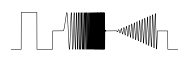

In [16]:
sns.set_style('white')

stimulus = load_hdf5(directories['misc'] + 'chirp.h5')['chirp']
stimulus_range = stimulus.max() - stimulus.min()

stimulus_time = np.linspace(0, 32, stimulus.shape[0])

fig, ax = plt.subplots(1)

ax.plot(stimulus_time, zscore(stimulus, single = False), color = 'k', linewidth = 0.5)

sns.despine(left = True, bottom = True, ax = ax)
plt.tick_params(axis='both', which='major', labelsize='small')

ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.set_xlim(0, 32)
# ax.set_aspect(1)

fig.set_size_inches(3, 0.75)

plt.savefig(directories['figs'] + 'reconstruct/' + 'chirp_stimulus_glu.svg', **fig_p)

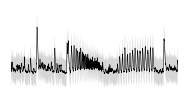

In [17]:
sns.set_style('white')

i_roi = 1

trace_mean = zscore(data_spiral['Snippets0'][:, :, i_roi], single = False).mean(axis = 1)
trace_std = zscore(data_spiral['Snippets0'][:, :, i_roi], single = False).std()
trace_time = data_spiral['SnippetsTimes0'][:, 0, i_roi]
trace_time -= trace_time.min()

fig, ax = plt.subplots(1)

ax.plot(trace_time, trace_mean, color = 'k', linewidth = 0.5)

ax.fill_between(
    trace_time,
    trace_mean + 2 * trace_std, 
    trace_mean - 2 * trace_std, 
    facecolor = 'k',
    alpha = 0.16
)

sns.despine(left = True, ax = ax)
ax.set_xlim(0, 66)
plt.tick_params(axis='both', which='major', labelsize='small')
ax.set_xlabel('', fontsize=10)
ax.set_xticklabels([]);
ax.set_yticklabels([]);
sns.despine(left = True, bottom = True, ax = ax)
# ax.set_aspect(1)

fig.set_size_inches(3, 1.5)

plt.savefig(directories['figs'] + 'reconstruct/' + 'mean_trace_glu.svg', **fig_p)

In [18]:
roi = np.unique(data_spiral_df['roi'])[0]

traces = data_spiral_df.loc[data_spiral_df['roi'] == roi, 'y']
tpnts  = data_spiral_df.loc[data_spiral_df['roi'] == roi, 'x_t']
tpnts_warp  = data_spiral_df.loc[data_spiral_df['roi'] == roi, 'x_t_warped']

stimulus_duration = 66

stimulus_mask = tpnts > (stimulus_duration / 2)

global_traces  = traces[stimulus_mask]
global_tpnts  = tpnts[stimulus_mask]
global_tpnts_warp = tpnts_warp[stimulus_mask]

local_traces  = traces[~stimulus_mask]
local_tpnts  = tpnts[~stimulus_mask]
local_tpnts_warp = tpnts_warp[~stimulus_mask]

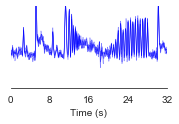

In [19]:
fig, ax = plt.subplots(1)

sample_colors = sns.color_palette('hls', n_samples)

offset = 0

for itx in range(n_samples):
    ax.plot(x_new, mu_post[:, 0, itx] + itx * offset, color = 'b', alpha = 0.5, linewidth = 0.5)
    
ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
sns.despine(ax = ax, left = True)
ax.set_ylim(-3, 3)

fig.set_size_inches(2.8, 1.5)

plt.savefig(directories['figs'] + 'warping/' + 'warped_gp_samples.svg', dpi = 300)

In [20]:
y_global = global_traces[:, None]
x_new_global = global_tpnts_warp[:, None]

m_global = GPy.models.SparseGPRegression(
    x_new_global,
    y_global,
    num_inducing = 300,
    kernel = GPy.kern.RBF(1)
)

m_global.optimize_restarts(4, messages = True, max_iters = 25)

y_local = local_traces[:, None]
x_new_local = local_tpnts_warp[:, None]

m_local = GPy.models.SparseGPRegression(
    x_new_local,
    y_local,
    num_inducing = 300,
    kernel = GPy.kern.RBF(1)
)

m_local.optimize_restarts(4, messages = True, max_iters = 25)

Optimization restart 1/4, f = 2731.8057153918326


Optimization restart 2/4, f = 3043.8613753363084


Optimization restart 3/4, f = 3058.0200419699386


Optimization restart 4/4, f = 3051.2607787715306


Optimization restart 1/4, f = 2745.6235353718994


Optimization restart 2/4, f = 3977.6160927071314


Optimization restart 3/4, f = 4055.376116333377


Optimization restart 4/4, f = 3983.131432566499


In [21]:
mu_local, sig_local = m_local.predict(x_new[:, None], include_likelihood = False)
_, sig_local_outer = m_local.predict(x_new[:, None], include_likelihood = True)

mu_global, sig_global = m_global.predict(x_new[:, None], include_likelihood = False)
_, sig_global_outer = m_global.predict(x_new[:, None], include_likelihood = True)

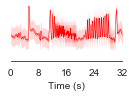

In [22]:
fig, ax = plt.subplots(1)

ax.plot(x_new_unwarp, mu_local, color = 'r', linewidth = 0.5)
upper, lower = compute_bounds(mu_local, sig_local, n_sigma = 2)
ax.fill_between(x_new_unwarp, upper[:, 0], lower[:, 0], facecolor = 'r', alpha = 0.33)
upper, lower = compute_bounds(mu_local, sig_local_outer, n_sigma = 2)
ax.fill_between(x_new_unwarp, upper[:, 0], lower[:, 0], facecolor = 'r', alpha = 0.16)

ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
sns.despine(ax = ax, left = True)
ax.set_ylim(-3, 3)

fig.set_size_inches(2, 1)

plt.savefig(directories['figs'] + 'glutamate/' + 'warped_gp_local.svg', dpi = 300)

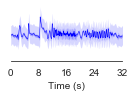

In [23]:
fig, ax = plt.subplots(1)

ax.plot(x_new_unwarp, mu_global, color = 'b', linewidth = 0.5)
upper, lower = compute_bounds(mu_global, sig_global, n_sigma = 2)
ax.fill_between(x_new_unwarp, upper[:, 0], lower[:, 0], facecolor = 'b', alpha = 0.33)
upper, lower = compute_bounds(mu_global, sig_global_outer, n_sigma = 2)
ax.fill_between(x_new_unwarp, upper[:, 0], lower[:, 0], facecolor = 'b', alpha = 0.16)

ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
sns.despine(ax = ax, left = True)
ax.set_ylim(-3, 3)

fig.set_size_inches(2, 1)

plt.savefig(directories['figs'] + 'glutamate/' + 'warped_gp_global.svg', dpi = 300)

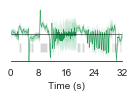

In [24]:
x_new_unwarp = iso_reg.transform(x_new)

fig, ax = plt.subplots(1)

ax.plot(x_new_unwarp, mu_global - mu_local, color = '#1a9850', linewidth = 0.5)
ax.plot(x_new_unwarp, np.zeros(x_new.shape), color = 'k', linewidth = 0.5)

upper, lower = compute_bounds(mu_global - mu_local, sig_global + sig_local, n_sigma = 3)
ax.fill_between(x_new_unwarp, upper[:, 0], lower[:, 0], facecolor = '#1a9850', alpha = 0.33)

diff_mask = (upper < 0) | (lower > 0)

y_min = - 1

ax.fill_between(
    x_new_unwarp, 
    np.ones(x_new_unwarp.shape) * 2 * y_min, 
    np.ones(x_new_unwarp.shape) * y_min, 
    where = diff_mask[:, 0], 
    facecolor = 'k', 
    alpha = 0.16
)

ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
sns.despine(ax = ax, left = True)
ax.set_ylim(-3, 3)

fig.set_size_inches(2, 1)

plt.savefig(directories['figs'] + 'glutamate/' + 'diff_gp.svg', dpi = 300)

In [25]:
n_sigma = np.linspace(0, 10, 200)

n_blob_inner = np.zeros(n_sigma.shape[0])

In [26]:
from scipy.ndimage import label

for itx, sigma in enumerate(n_sigma):
    # Compute inner EC
    upper, lower = compute_bounds(mu_global - mu_local, sig_global + sig_local, n_sigma = sigma)
    ax.fill_between(x_new_unwarp, upper[:, 0], lower[:, 0], facecolor = '#1a9850', alpha = 0.33)

    diff_mask = (upper < 0) | (lower > 0)
    
    n_blob_inner[itx] = np.unique(np.hstack(label(diff_mask)[0])).max()

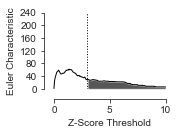

In [27]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

ax.plot(n_sigma, n_blob_inner, color = 'k', label = 'Latent', linewidth = 1, clip_on = False)
ax.plot(np.ones(240) * 3, np.arange(240), color = 'k', linewidth = 1, linestyle = ':')

sigma_mask = n_sigma > 3
ax.fill_between(
    n_sigma[sigma_mask], 
    np.zeros(n_sigma[sigma_mask].shape), 
    n_blob_inner[sigma_mask],
    facecolor = 'k', 
    alpha = 0.66,
    clip_on = False
)

ax.set_xlim(0, 10)
ax.set_ylim(0, 240)
plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.xticks(np.arange(0, 15, 5))
plt.yticks(np.arange(0, 280, 40))

sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2, 1.4)

plt.savefig(directories['figs'] + 'glutamate/' + 'zscore_vs_ec.svg', dpi = 300)

Approximate Null-Distribution

In [39]:
x_predict = x_new # remove in cleanup

y_pool = np.hstack([y_local[:, 0], y_global[:, 0]])
x_new_pool = np.hstack([x_new_local[:, 0], x_new_global[:, 0]])

n_bootstrap = 500
n_samples = 300

array_shape = [n_bootstrap, x_predict.shape[0]]
mB1_mu, mB1_sig = np.zeros(array_shape), np.zeros(array_shape)
mB2_mu, mB2_sig = np.zeros(array_shape), np.zeros(array_shape)

for itx in tqdm.tqdm(range(n_bootstrap)):
    np.random.seed(itx)
    
    all_boot_samples = np.random.choice(y_pool.shape[0], n_samples * 2, replace = False)
    
    B1_samples = all_boot_samples[:n_samples]
    B2_samples = all_boot_samples[n_samples:]
    
    # Bootstrap 1
    mB1 = GPy.models.GPRegression(
        x_new_pool[B1_samples, None],
        y_pool[B1_samples, None],
        kernel = GPy.kern.RBF(1),
    )

    mB1.optimize_restarts(1, max_iters = 25, verbose = False)

    mB1_mu_temp, mB1_sig_temp = mB1.predict(x_predict[:, None], include_likelihood = False)
    mB1_mu[itx, :] = mB1_mu_temp[:, 0]
    mB1_sig[itx, :] = mB1_sig_temp[:, 0]
    
    # Bootstrap 2
    mB2 = GPy.models.GPRegression(
        x_new_pool[B2_samples, None],
        y_pool[B2_samples, None],
        kernel = GPy.kern.RBF(1),
    )

    mB2.optimize_restarts(1, max_iters = 25, verbose = False)

    mB2_mu_temp, mB2_sig_temp = mB2.predict(x_predict[:, None], include_likelihood = False)
    mB2_mu[itx, :] = mB2_mu_temp[:, 0]
    mB2_sig[itx, :] = mB2_sig_temp[:, 0]

n_blob_bootstrap = np.zeros([n_bootstrap, n_sigma.shape[0]])

for ity in tqdm.tqdm(range(n_bootstrap)):
    for itx, sigma in enumerate(n_sigma):
        upper, lower = compute_bounds(mB1_mu[ity, :] - mB2_mu[ity, :], mB1_sig[ity, :] + mB2_sig[ity, :], n_sigma = sigma)

        diff_mask = (upper < 0) | (lower > 0)

        n_blob_bootstrap[ity, itx] = np.unique(np.hstack(label(diff_mask)[0])).max()

  7%|▋         | 33/500 [01:26<23:40,  3.04s/it] /usr/local/lib/python3.6/dist-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /usr/local/lib/python3.6/dist-packages/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square
 /usr/local/lib/python3.6/dist-packages/GPy/kern/src/rbf.py:54: RuntimeWarning:invalid value encountered in multiply
100%|██████████| 500/500 [06:24<00:00,  1.26it/s]


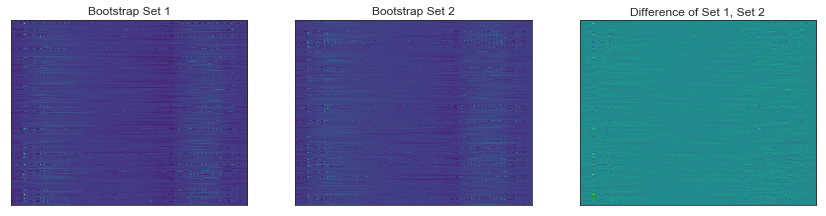

In [40]:
sns.set_style('white')

fig, ax = plt.subplots(1, 3)

ax[0].set_title('Bootstrap Set 1')
ax[0].imshow(mB1_mu, cmap = 'viridis')

ax[1].set_title('Bootstrap Set 2')
ax[1].imshow(mB2_mu, cmap = 'viridis')

ax[2].set_title('Difference of Set 1, Set 2')
ax[2].imshow(mB1_mu - mB2_mu, cmap = 'viridis')

for itx in range(3):
    ax[itx].set_xticklabels([]);
    ax[itx].set_yticklabels([]);
    
fig.set_size_inches(12, 3)
plt.tight_layout()

In [41]:
from scipy.stats import percentileofscore

def calc_boot_perc(n_blob_bootstrap, n_blob_inner, n_sigma, sigma = 3):
    mask = n_sigma < 3
    p_ = percentileofscore(
        n_blob_bootstrap[:, mask][:, -1], 
        n_blob_inner[mask][-1]
    )

    return p_

calc_boot_perc(n_blob_bootstrap, n_blob_inner, n_sigma)

100.0

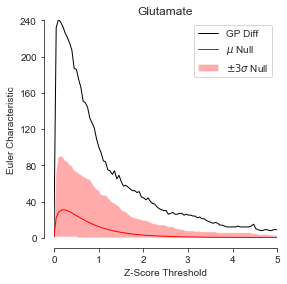

In [42]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

plt.title('Glutamate', fontsize = 12)
ax.plot(n_sigma, n_blob_inner, color = 'k', linewidth = 1, clip_on = True, label = 'GP Diff')
ax.plot(n_sigma, n_blob_bootstrap.mean(axis = 0), color = 'r', linewidth = 1, label = '$\mu$ Null');

ax.fill_between(
    n_sigma, 
    np.percentile(n_blob_bootstrap, 0.3, axis = 0), 
    np.percentile(n_blob_bootstrap, 99.7, axis = 0),
    facecolor = 'r', alpha = 0.33, clip_on = True,
    label = '$\u00B13\sigma$ Null'
)

plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(0, 280, 40))
ax.set_xlim(0, 5)
ax.set_ylim(0, 240)
plt.legend()

sns.despine(ax = ax, offset = 10)
fig.set_size_inches(4, 4)

plt.savefig(directories['figs'] + 'bootstrap/' + 'glutamate-bootstrap.svg', dpi = 300)

Classical Comparison

In [43]:
i_roi = 1
local_traces = data_spiral['Snippets0'][:16515, :, i_roi]
global_traces = data_spiral['Snippets0'][16515:, :, i_roi]

local_mean = local_traces.mean(axis = 1)
global_mean = global_traces.mean(axis = 1)

local_std = local_traces.std(axis = 1)
global_std = global_traces.std(axis = 1)

trace_times = data_spiral['SnippetsTimes0'][:16515, 0, i_roi] / 2
trace_times -= trace_times.min()

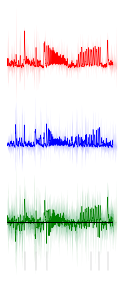

In [44]:
fig, ax = plt.subplots(1)

offset = 15

ax.plot(trace_times, local_mean + 2 * offset, color = 'r', linewidth = 0.5)
ax.fill_between(trace_times, local_mean - 3 * local_std + 2 * offset,  local_mean + 3 * local_std + 2 * offset,
                facecolor = 'r', alpha = 0.33, clip_on = False)

ax.plot(trace_times, global_mean + offset, color = 'b', linewidth = 0.5)
ax.fill_between(trace_times, global_mean - 3 * global_std + offset,  global_mean + 3 * global_std + offset, 
                facecolor = 'b', alpha = 0.33, clip_on = False)

ax.plot(trace_times, local_mean - global_mean, color = 'g', linewidth = 0.5)
ax.plot(np.arange(33), np.zeros(33), color = 'k', linewidth = 1)

ax.fill_between(trace_times, 
                local_mean - global_mean - 3 * (local_std + global_std),  
                local_mean - global_mean + 3 * (local_std + global_std), 
                facecolor = 'g', alpha = 0.33, clip_on = False)


upper, lower = compute_bounds(local_mean - global_mean, local_std + global_std, n_sigma = 3)
ax.fill_between(trace_times, upper, lower, facecolor = '#1a9850', alpha = 0.33)

diff_mask = (upper < 0) | (lower > 0)

y_min = - 5.5

ax.fill_between(
    trace_times, 
    np.ones(trace_times.shape) * y_min, 
    np.ones(trace_times.shape) * y_min - 3.5, 
    where = diff_mask, 
    facecolor = 'k', 
    alpha = 0.16
)

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

ax.set_xlim(0, 32)
ax.set_ylim(-11, 40)

plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)

sns.despine(left = True, bottom = True, ax = ax, offset = 10)

fig.set_size_inches(1.9, 5)

plt.savefig(directories['figs'] + 'glutamate/' + 'classical_diff.pdf', dpi = 300)

In [45]:
n_blob_inner = np.zeros(n_sigma.shape[0])

for itx, sigma in enumerate(n_sigma):
    # Compute EC
    upper, lower = compute_bounds(local_mean - global_mean, local_std + global_std, n_sigma = sigma)
    ax.fill_between(trace_times, upper, lower, facecolor = '#1a9850', alpha = 0.33)

    diff_mask = (upper < 0) | (lower > 0)
    
    n_blob_inner[itx] = np.unique(np.hstack(label(diff_mask)[0])).max()

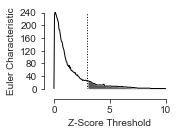

In [46]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

ax.plot(n_sigma, n_blob_inner, color = 'k', label = 'Latent', linewidth = 1, clip_on = False)
ax.plot(np.ones(240) * 3, np.arange(240), color = 'k', linewidth = 1, linestyle = ':')

sigma_mask = n_sigma > 3
ax.fill_between(
    n_sigma[sigma_mask], 
    np.zeros(n_sigma[sigma_mask].shape), 
    n_blob_inner[sigma_mask],
    facecolor = 'k', 
    alpha = 0.66,
    clip_on = False
)

ax.set_xlim(0, 10)
ax.set_ylim(0, 240)
plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.xticks(np.arange(0, 15, 5))
plt.yticks(np.arange(0, 280, 40))

sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2, 1.4)

plt.savefig(directories['figs'] + 'glutamate/' + 'classical_EC_glu.svg', dpi = 300)

In [47]:
y_pool = np.hstack([local_traces, global_traces])
y_sig_pool = np.hstack([local_std, global_std])
x_new_pool = np.hstack([trace_times, trace_times])

n_blob_out = []

n_bootstrap = 500

array_shape = [n_bootstrap, 16515]
mB1_mu, mB1_sig = np.zeros(array_shape), np.zeros(array_shape)
mB2_mu, mB2_sig = np.zeros(array_shape), np.zeros(array_shape)

for itx in tqdm.tqdm(range(n_bootstrap)):
    np.random.seed(itx)

    all_boot_samples = np.random.choice(y_pool.shape[1], y_pool.shape[1], replace = False)
    n_samples = y_pool.shape[1] // 2

    B1_samples = all_boot_samples[:n_samples]
    B2_samples = all_boot_samples[n_samples:]

    # Bootstrap 1
    mB1_mu[itx, :] = y_pool[:, B1_samples].mean(axis = 1)
    mB1_sig[itx, :] = y_pool[:, B1_samples].std(axis = 1)

    # Bootstrap 2
    mB2_mu[itx, :] = y_pool[:, B2_samples].mean(axis = 1)
    mB2_sig[itx, :] = y_pool[:, B2_samples].std(axis = 1)

n_blob_bootstrap = np.zeros([n_bootstrap, n_sigma.shape[0]])

for ity in tqdm.tqdm(range(n_bootstrap)):
    for itx, sigma in enumerate(n_sigma):
        upper, lower = compute_bounds(mB1_mu[ity, :] - mB2_mu[ity, :], mB1_sig[ity, :] + mB2_sig[ity, :], n_sigma = sigma)

        diff_mask = (upper < 0) | (lower > 0)

        n_blob_bootstrap[ity, itx] = np.unique(np.hstack(label(diff_mask)[0])).max()

100%|██████████| 500/500 [1:15:03<00:00,  7.91s/it]


In [48]:
from scipy.stats import percentileofscore

def calc_boot_perc(n_blob_bootstrap, n_blob_inner, n_sigma, sigma = 3):
    mask = n_sigma < 3
    p_ = percentileofscore(
        n_blob_bootstrap[:, mask][:, -1], 
        n_blob_inner[mask][-1]
    )

    return p_

calc_boot_perc(n_blob_bootstrap, n_blob_inner, n_sigma)

93.8

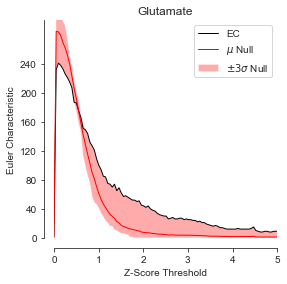

In [51]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

plt.title('Glutamate', fontsize = 12)

ax.plot(n_sigma, n_blob_inner, color = 'k', linewidth = 1, clip_on = True, label = 'EC')
ax.plot(n_sigma, n_blob_bootstrap.mean(axis = 0), color = 'r', linewidth = 1, label = '$\mu$ Null');

ax.fill_between(
    n_sigma, 
    np.percentile(n_blob_bootstrap, 0.3, axis = 0), 
    np.percentile(n_blob_bootstrap, 99.7, axis = 0),
    facecolor = 'r', alpha = 0.33, clip_on = True,
    label = '$\u00B13\sigma$ Null'
)

ax.fill_between(
    n_sigma, 
    np.ones(n_sigma.shape[0]) - 10, 
    np.ones(n_sigma.shape[0]) - 30, 
    where = n_blob_inner > np.percentile(n_blob_bootstrap, 99.7),
    facecolor = 'k', alpha = 0.33, clip_on = True
)

plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(-40, 280, 40))
ax.set_xlim(0, 5)
ax.set_ylim(0, 300)
plt.legend()

sns.despine(ax = ax, offset = 10)
fig.set_size_inches(4, 4)

plt.savefig(directories['figs'] + 'bootstrap/' + 'glutamate-classical-bootstrap.svg', dpi = 300)